<H1>Predicción de Ausencia de Paciente a su Cita Medica </H1>

<H2>Ejemplo de predicción con Logistic Regression y exportación a PMML</H2>

El ejemplo esta basado en 100 000 Citas medicas de una región (Vitória, Espírito Santo) de Brazil.
En base a caracteristicas demograficas, sociales y de enfermedades cronicas del paciente, se intenta determinar su presencia/ausencia en la cita programada.


Este ejemplo simple sirve para mostrar los aspectos siguientes
<ul>
    <li><em>Conexión desde Spark o PyODBC o JDBC a la plataforma InterSystems IRIS</em<</li>
    <li><em>Acceso a un modelo de Datos Preparado para ML (Abstract Base Table)</em></li>
    <li><em>Entrenamiento de un algorithmo simple</em></li>
    <li><em>Exportación a PMML para la Operacionalización en InterSystems IRIS</em></li>
 </ul>


  Para mas claridad, este ejemplo ha sido reducido al maximo. No pretende enseñar mejores practicas de Python, ML, o estadisticas... Se pueden encontrar mas ejemplos y detalles de investigación sobre este mismo dataset en varios sitios, como por ejemplo:
  <ul>
    <li>[github](https://github.com/dovidburns/Doctor_Appointment_No_Shows)</li>
    <li>[kaggle](https://www.kaggle.com/somrikbanerjee/predicting-show-up-no-show)</li>
    <li>[Data Analytics and Modeling for Appointment No-show in Community Health Centers](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6243417/)</li>
    <li>[Designing risk prediction models for ambulatory no-shows across different specialties and clinics](https://academic.oup.com/jamia/article/25/8/924/4849782)</li>
 </ul>

<H2>Carga de Librerias Python</H2>

In [1]:
#Carga inicial de librerias imprescindibles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import seaborn as sns
#sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

#ML imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

#Pipeline needed for PMML Export
from sklearn.pipeline import Pipeline
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import make_pmml_pipeline
from sklearn2pmml import sklearn2pmml


from sklearn import metrics
from sklearn.metrics import roc_curve
#from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

#Connexión jdbc para este ejemplo
import jaydebeapi

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


   ## Carga de los Datos Preparados
   
   Se accede a una projección de los datos (Abstract Base Table), con datos preparados para ML y columnas de categoria ya pre-expandidas en "One Hot Encoding" (Gender_F, Gener_M).
   Se ha reducido a proposito el numero de columnas proyectados aquí:
   <ul>
    <li>PublishedABT.MLSimpleAppointmentGetfeatures():  11 Columnas </li>
    <li>PublishedABT.MLAppointmentGetfeatures():       110 columnas </li>
   </ul>
   
   <em>Nota: En este ejemplo, su usa una simple conexión jdbc a IRIS, y se trabaja con un Pandas Dataframe.
    Ver más abajo para un ejemplo de conexión nativa Spark
    </em>

In [2]:
cxn=jaydebeapi.connect("com.intersystems.jdbc.IRISDriver","jdbc:IRIS://iris4ml:51773/MLACADEMY",  ["SuperUser", "sys"], "/usr/local/lib/intersystems/intersystems-jdbc-3.1.0.jar")
data=pd.read_sql('select top 20000 * from PublishedABT.MLSimpleAppointmentsGetfeatures()',cxn)
cxn.close()

In [3]:
#Las primeras filas de datos
data.head()

,Age,Alcoholism,Delay,Diabetes,Gender_F,Gender_M,Handicap,Hypertension,Scholarship,noShow,smsReceived
0,62,False,0,False,1,0,0,True,False,False,False
1,56,False,0,False,0,1,0,False,False,False,False
2,62,False,0,False,1,0,0,False,False,False,False
3,8,False,0,False,1,0,0,False,False,False,False
4,56,False,0,True,1,0,0,True,False,False,False


In [4]:
#Y un recuento de los Nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Age           50000 non-null  int64
 1   Alcoholism    50000 non-null  bool 
 2   Delay         50000 non-null  int64
 3   Diabetes      50000 non-null  bool 
 4   Gender_F      50000 non-null  int64
 5   Gender_M      50000 non-null  int64
 6   Handicap      50000 non-null  int64
 7   Hypertension  50000 non-null  bool 
 8   Scholarship   50000 non-null  bool 
 9   noShow        50000 non-null  bool 
 10  smsReceived   50000 non-null  bool 
dtypes: bool(6), int64(5)
memory usage: 2.2 MB


<H1>Algoritmo ML de Logistic Regression</H1> 

es un algoritmo relativamente simple, y los resultados obtenidos sobre este conjunto de datos parcial (hemos limitado el numero de columnas para hacer algo mas simple en este tutorial) son "pasables". Aún así, nos permite ver como se genera el PMML y se pone en producción.

In [5]:
#Extracción de las Caracteristicas (en X) y del Resultado (columna "noShow" en y) como arrays numpy...
X = data.loc[:, ~data.columns.isin(['noShow'])].values
y = data.loc[:, 'noShow'].values

In [6]:
#Se separan los datos (110 000 filas) en 2 conjuntos: Train para entrenar,
# y test para validar los resultados del algoritmo
# 0.2 => 20% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,) 

In [7]:
#Entrenamiento del Algoritmo Regresión Logistica, con "cross validation"
modelLR = LogisticRegressionCV(n_jobs=-1, cv=10, max_iter=200, scoring = 'f1',multi_class='ovr')
modelLR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=200, multi_class='ovr', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring='f1',
                     solver='lbfgs', tol=0.0001, verbose=0)

In [8]:
#Evaluación del modelo entrenado, sobre los datos de test
y_pred = modelLR.predict(X_test)

In [9]:
#Visualización de las metricas de Resultados
# Se han predecido casi ninguna ausencia con estos parametros del algorithmo (0.03)
print(metrics.f1_score(y_test, y_pred))

0.03789673140691615


In [10]:
# si bajamos el umbral de decision Show/noShow a una probabilidad de 0.32, obtenemos una mejora en el score f1...
y_pred_prob = modelLR.predict_proba(X_test)[:,1] >.32
print(metrics.f1_score(y_test, y_pred_prob))

0.2222222222222222


In [11]:
# La accuracy es mejorable....
# https://developers.google.com/machine-learning/crash-course/classification/accuracy
accuracy_score(y_test,y_pred_prob)

0.7739

In [12]:
# we have a decent somewhat poor AUC of 0.67
metrics.roc_auc_score(y_test,modelLR.predict_proba(X_test)[:,1])

0.6701187105777723

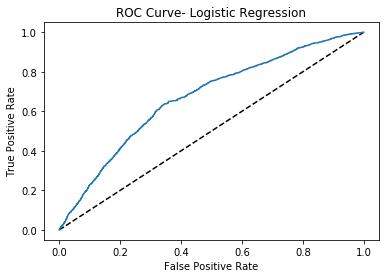

In [13]:
y_pred_prob = modelLR.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')
plt.show()

<H1>Exportación a PMML</H1>

la exportación a PMML se puede hacer con sklearn2pmml y usa jpmml por debajo.
Es necesario definir un PMMLPipeline, al cual se podrían añadir etapas de pre-procesamiento que nio necesitamos aqui.
[Introducciçon sklearn2pmml](https://www.slideshare.net/VilluRuusmann/converting-scikitlearn-to-pmml)

In [14]:
#Extraimos los nombre de columnas de caracteristicas para añadirlas a la definición PMML
features=list(data.columns)
features.remove('noShow')
#print(len(features))

In [15]:
#Se crea el Pipelinne
myPipeline=Pipeline([('LogisticRegression',modelLR)])
myPMMLPipeline=make_pmml_pipeline(myPipeline,active_fields=features,target_fields=["noShow"])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [16]:
sklearn2pmml(myPMMLPipeline, pmml="/root/mlacademy/MLAcademy.SimpleLR.pmml")

<H1> Pruebas de Validación </H1>

In [17]:
#Predicción sobre la primera fila
print(modelLR.predict_proba(X[1].reshape(1,-1)))

[[0.86113226 0.13886774]]


In [18]:
#Predicción sobre los mismos datos que hemos enviado via REST
Z=np.array([53,0,181,0,0,1,0,1,1,1]) #"Age":53 "Delay":181,"Diabetes":0,"Gender_F":0,"Gender_M":1,   "Handicap":0,    "Hypertension":1,"Scholarship":1,"smsReceived":1
print(modelLR.predict_proba(Z.reshape(1,-1)))

[[0.02710548 0.97289452]]


<H1>Acceso desde Spark</H1>

<H2>Ejemplo de Acceso con Adaptador nativo Spark</H2>

Apache Spark permite distribuir las tareas a relizar en varios nodos, y ofrece una escalabilidad horizontal que permite trabaja con conjuntos de datos mas grandes que no caben en memoria.
El Adapatador nativo para Spark de Intersystems se adapta a a topologia (shard-aware) y permite ejecutar codigo cerca de los datos.


In [ ]:
#Verificación que pydpark este funcionando, para poder acceder a los datos en IRIS
import sys
print (sys.version)
sc

In [ ]:
sc._conf.getAll()

In [ ]:
#Carga del Modelo 'Abstract Base Table en un Spark DataFrame
sp_df=spark.read.format("iris").\
option("fetchsize",200).\
option("url", "IRIS://iris4ml:51773/MLACADEMY").\
option("user", "SuperUser").\
option("password", "sys").\
option("query", "PublishedABT.MLSimpleAppointmentsGetfeatures()").\
load().\
limit(2000) 

In [ ]:
#Mostrar Informacion de filas & columnas
#print((sp_df.count(), len(sp_df.columns)))

In [ ]:
#Mostrar las columnas de caracteristicas y la columna de resultado (Classification == Presente/Ausente) 
#sp_df.columns
#sp_df.show(5)
sp_df.printSchema()

   ### Copia de Spark RDD a un Pandas DataFrame

In [ ]:
#Limitar la memoria usada en JVM 
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch","100")

In [ ]:
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# Convert the Spark DataFrame back to a Pandas DataFrame using Arrow
# ((Nota: requiere fechas como TimeStamp (no funciona bien con Dates) ))
data = sp_df.select("*").toPandas()
# data.drop(['ID'],axis=1,inplace=True)  #Eliminamos las columnas de ID, no sirven para determinar el resultado